In [2]:
import pandas_datareader.data as pdr
import datetime as dt
import pandas as pd
import numpy as np
start_date = dt.date.today() - dt.timedelta(3650)
end_date = dt.date.today()
tickers  = ['MSFT']
ohlcv = pdr.get_data_yahoo(tickers[0],start_date,end_date)
df = ohlcv.copy()

c:\users\aditya-asuszenbook\appdata\local\programs\python\python38\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# MACD


In [3]:
def MACD(Df,a,b,c):
    df = Df.copy()
    df['MA_Fast'] = df['Adj Close'].ewm(span = a , min_periods = a).mean()
    df['MA_Slow'] = df['Adj Close'].ewm(span = b , min_periods = b).mean()
    df['MACD'] = df['MA_Fast'] - df['MA_Slow']
    df['Signal'] = df['MACD'].ewm(span = c ,min_periods = c).mean()
    df.dropna(inplace=True)
    return df


# ATR

In [4]:
def ATR(Df,n):
    df = Df.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Adj Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Adj Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2
    

## Bollinger Band

In [6]:
def BollBnd(Df,n):
    df = Df.copy()
    df['MA'] = df['Adj Close'].rolling(n).mean()
    df['BB_up'] = df['Adj Close'].rolling(n).mean() + 2*df['MA'].rolling(n).std()
    df['BB_dn'] = df['Adj Close'].rolling(n).mean() - 2*df['MA'].rolling(n).std()
    df['BB_Width'] = df['BB_up'] - df['BB_dn']
    df.dropna(inplace=True)
    return df

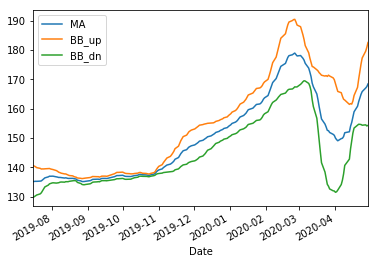

In [7]:
BollBnd(ohlcv,20).iloc[-200:,[6,7,8]].plot()

# RSI


In [8]:
def RSI(Df,n):
    df = Df.copy()
    df['delta'] = df['Adj Close'] - df['Adj Close'].shift(1)
    df['gain'] = np.where(df['delta']>=0,df['delta'],0)
    df['loss'] = np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    
    df['avg_gain'] = np.array(avg_gain)
    df['avg_loss'] = np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    return df
            

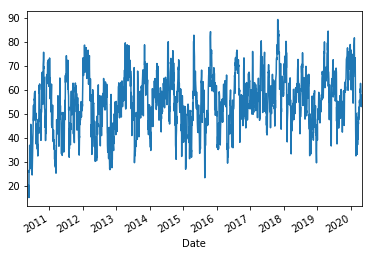

In [9]:
RSI(ohlcv,14)['RSI'].plot()

# ADX

In [10]:
def ADX(DF,n):
    "function to calculate ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX']=np.array(ADX)
    return df2['ADX']

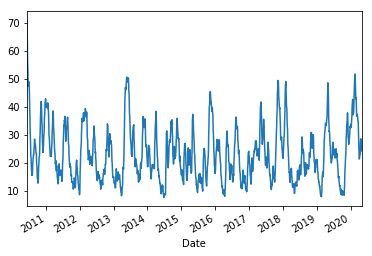

In [11]:
ADX(ohlcv,14).dropna().plot()

In [3]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-08-12,24.680000,24.360001,24.420000,24.490000,70240500.0,19.346718
2010-08-13,24.670000,24.240000,24.350000,24.400000,45263500.0,19.275618
2010-08-16,24.610001,24.299999,24.360001,24.500000,40909700.0,19.354610
2010-08-17,24.959999,24.600000,24.709999,24.709999,52912600.0,19.624645
2010-08-18,24.950001,24.410000,24.680000,24.820000,46818900.0,19.712004
...,...,...,...,...,...,...
2020-08-04,214.770004,210.309998,214.169998,213.289993,49280100.0,213.289993
2020-08-05,215.000000,211.570007,214.899994,212.940002,28858600.0,212.940002
2020-08-06,216.369995,211.550003,212.339996,216.350006,32656800.0,216.350006
